In [385]:
%matplotlib inline
import numpy as np
#from autograd import numpy as np
import bayesian_pdes as bpdes
from scipy import stats
import matplotlib.pyplot as plt
import mcmc
import sympy as sp
import os
%load_ext mcmc
%mcmc notebook

The mcmc extension is already loaded. To reload it, use:
  %reload_ext mcmc


In [386]:
use_dummy_data = False
dummy_data_file = os.path.join('dummy_data', 'centered_blob')

In [387]:
scale = 1000
stim_current = 1.0

kernel_variance_mult = 1e-2
kernel_ls = 0.3
conductivity_variance_mult = 1. # 1e-3 is good
conductivity_ls = 0.3
run_time = 11

likelihood_variance = 1e-6 # variance for the observation model - based on the value from RA paper

In [388]:
baseline = np.loadtxt('recovered_rhos.csv', delimiter=',')
baseline_xy = baseline[:,:2]
baseline_fields = baseline[:,2:]

# Sheet Parameters

In [389]:
# important helpers!
def cart2pol(points):
    x = points[:,0]
    y = points[:,1]
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return np.column_stack([rho, phi])

def pol2cart(points):
    rho = points[:,0]
    phi = points[:,1]
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return np.column_stack([x, y])

def plot_circle(x, y, values, cmap=None):
    plt.tripcolor(x.ravel(), y.ravel(), values.ravel(), cmap=cmap)
    plt.colorbar()
    plt.legend()
    plt.axis('scaled')
    plt.xlim(-1.1,1.1); plt.ylim(-1.1,1.1);

In [390]:
# code for setting up the stim pattern
stim_pattern = np.zeros((7,8))
for i in xrange(7):
    stim_pattern[i,0] = 1
    stim_pattern[i, i+1] = -1
stim_pattern = stim_pattern*stim_current

In [391]:
meas_pattern = np.zeros((7,8))
meas_pattern[:,0] = 1
meas_pattern[:, 1:] = np.diag(-np.ones(7))

# Load Data

In [392]:
data_file = '../data/ST1trial3.DAT'
raw_data = np.loadtxt(data_file)

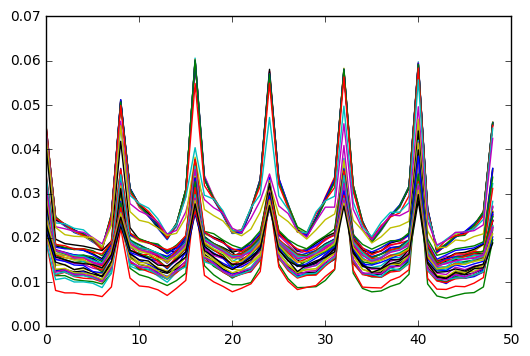

In [393]:
plt.plot(raw_data[:,1:].T);

In [394]:
raw_data.shape

(49, 50)

The data file format is as follows:
* Each row corresponds to a time
* The first element of the row gives the time index of the measurement
* The remaining columns give the measurements for each time
* These are divided into seven blocks.
    - Call the block $i$
    - Within the block the measurements correspond to electrodes $j=1,\dots,8$, $j\neq i$
    - Pair $(i,j)$ represents passing a current between electrode $i$ and electrode $j$ and measuring the voltage.
    - The voltage is measured between the _reference_ electrode at $1$ and the electrode located at $1+i$

_Is there not one too many electrodes here? This implies at some point we measure the voltage between 1 and 2 based on a current driven between 1 and 2._

_Is there a linear independence problem here? I still think there might be._

In [395]:
def data_to_dict(data):
    res = {}
    for r in data:
        time = r[0]
        other_data = r[1:]
        res[time] = scale*other_data.reshape((7,7))
    return res

In [396]:
data_dict = data_to_dict(raw_data)
# quick check to make sure the data dict matches expectation
assert np.all(data_dict[1][0] == scale*raw_data[0][1:8])

In [397]:
dummy_data = np.load(os.path.join(dummy_data_file, 'obs.npy'))
dummy_true_field = np.load(os.path.join(dummy_data_file, 'theta.npy'))

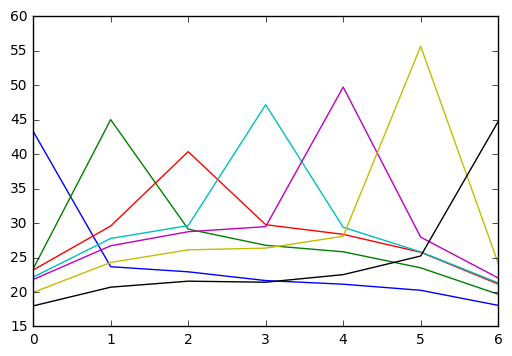

In [398]:
plt.plot(data_dict[run_time]);

# Set Up

In [399]:
from bayesian_pdes.problems import eit

In [400]:
s_x, s_xbar, s_y, s_ybar = sp.symbols('x,xbar,y,ybar')
a, a_x, a_y = sp.symbols('a,a_x,a_y')
a_bar, a_x_bar, a_y_bar = sp.symbols('abar,a_xbar,a_ybar')
s_length_scale, s_variance = sp.symbols('l,sigma')
kernel = s_variance*sp.exp(-((s_x-s_xbar)**2 + (s_y-s_ybar)**2) / (2.*s_length_scale**2))
symbols = [[s_x, s_y, a, a_x, a_y], [s_xbar, s_ybar, a_bar, a_x_bar, a_y_bar], [s_length_scale, s_variance]]

Use:
\begin{align*}
    \nabla \cdot (\exp(a)\nabla u) &= \nabla \exp(a) \cdot \nabla u + \exp(a) \nabla^2 u \\
    &= \exp(a) \left( \nabla a \cdot \nabla u + \nabla^2 u \right) \\
    &= \exp(a) \left( a_x u_x + a_y u_y + u_{xx} + u_{yy} \right)
\end{align*}
and:
\begin{align*}
    \exp(a) \nabla u \cdot n &= \exp(a) (x u_x + y u_y)
\end{align*}
for the special case of a unit circular domain centered at the origin.

In [401]:
def A(k):
    return sp.exp(a)*(k.diff(s_x,s_x) + k.diff(s_y,s_y) + k.diff(s_x)*a_x + k.diff(s_y)*a_y)
def A_bar(k):
    return sp.exp(a_bar)*(k.diff(s_xbar,s_xbar) + k.diff(s_ybar,s_ybar) + k.diff(s_xbar)*a_x_bar + k.diff(s_ybar)*a_y_bar)
def B(k):
    return sp.exp(a)*(k.diff(s_x)*s_x + k.diff(s_y)*s_y)
def B_bar(k):
    return sp.exp(a_bar)*(k.diff(s_xbar)*s_xbar + k.diff(s_ybar)*s_ybar)

In [402]:
op_system = bpdes.operator_compilation.sympy_gram.compile_sympy(
    [A, B], [A_bar, B_bar],
    kernel,
    symbols,
    parallel=True
)

In [403]:
#op_system_factory = eit.EITFactory(kernel, symbols[0], symbols[1], symbols[2])

## Define the collocation grid

In [404]:
r = 1.0 # todo: just assume a unit radius, is this okay?
n_in_shell = 10

In [405]:
def construct_shell(radii):
    r_spacing = radii[1] - radii[0]
    coords = [np.array([[0.,0.]])]
    for r in radii:
        # at each 'shell' we want a roughly equal number of theta around the diameter.
        # each theta should be about r_spacing apart
        n_theta = np.round(2*np.pi*r / r_spacing)
        thetas = np.linspace(0, 2*np.pi, n_theta+1)[:-1]
        x = np.cos(thetas)
        y = np.sin(thetas)
        coords.append(r*np.c_[x,y])
    coords = np.concatenate(coords)
    return coords


In [406]:
shell_radii = np.linspace(0, r, n_in_shell)[1:-1]
design_int = construct_shell(shell_radii)

In [407]:
n_bdy = 64
bdy_theta = np.linspace(0, 2*np.pi, n_bdy+1)
design_bdy = pol2cart(np.c_[np.ones(n_bdy), bdy_theta[:-1]]) 

# define the mapping from boundary collocation point to sensor
bdy_sensor_skip = 8
sensor_ixs = np.arange(0, len(design_bdy), bdy_sensor_skip)
is_sensor_flags = np.in1d(np.arange(len(design_bdy)), sensor_ixs)

sensor_xy = design_bdy[is_sensor_flags]
non_sensor_xy = design_bdy[~is_sensor_flags]
print('{} sensors'.format(len(sensor_xy)))
print('{} non-sensors'.format(len(non_sensor_xy)))

8 sensors
56 non-sensors


In [408]:
# for now we impose the BC only at the sensor locations and impose the interior condition at non-sensor bdy points
modified_design_int = np.row_stack([design_int, non_sensor_xy])
modified_design_bdy = sensor_xy

In [409]:
full_design = np.row_stack([modified_design_int, modified_design_bdy])
len(full_design)

291

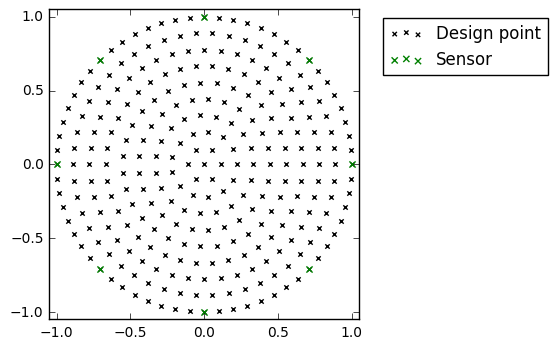

In [410]:
# plot design points
plt.figure(figsize=(4,4))
plt.scatter(design_int[:,0], design_int[:,1], marker='x', color='black', s=10)
plt.scatter(design_bdy[:,0], design_bdy[:,1], marker='x', color='black', s=10, label='Design point')
plt.scatter(sensor_xy[:,0], sensor_xy[:,1], marker='x', color='green', label='Sensor')
plt.xlim(-r*1.05,r*1.05);plt.ylim(-r*1.05,r*1.05)
plt.legend(loc=2, bbox_to_anchor=(1.05,1))

## Define the Potential

In [411]:
# todo: choose this in a more principled way
length_scale = 0.3
fun_args = np.array([kernel_ls, kernel_variance_mult])

In [412]:
def construct_posterior(theta, debug=False):
    a_int, a_bdy, a_x, a_y = theta_to_a(theta,
                                        modified_design_int.shape[0], 
                                        modified_design_bdy.shape[0]
                                       )
    
    augmented_int = np.column_stack([modified_design_int, a_int, a_x, a_y])
    augmented_bdy = np.column_stack([modified_design_bdy, a_bdy, np.nan*np.zeros((a_bdy.shape[0], 2))])
    obs = [
        (augmented_int, None),
        (augmented_bdy, None)
    ]
    posterior = bpdes.collocate(
        op_system.operators,
        op_system.operators_bar,
        obs,
        op_system,
        fun_args,
        inverter='np'
    )
    return posterior

In [413]:
def phi(theta, debug=False):
    # first solve forward
    posterior = construct_posterior(theta, debug=debug)
    # now determine voltage at the sensor locations
    # we have seven observations so take one for each sensor other than sensor 1, the reference sensor
    augmented_locations = np.column_stack([sensor_xy, np.nan*np.zeros((8,3))])
    mu_mult, Sigma = posterior.no_obs_posterior(augmented_locations)
    
    # now need to iterate the stim patterns and compute the residual
    data = data_dict[run_time] if not use_dummy_data else dummy_data
    rhs_int = np.zeros((len(modified_design_int), 1))
    
    Sigma_obs = np.dot(meas_pattern, np.dot(Sigma, meas_pattern.T))
    likelihood_cov = Sigma_obs + likelihood_variance*np.eye(Sigma_obs.shape[0])
    #likelihood_cov = likelihood_variance*np.eye(Sigma_obs.shape[0])
    likelihood_dist = stats.multivariate_normal(np.zeros(Sigma_obs.shape[0]), likelihood_cov)
    
    if debug:
        print("Sigma diag: {}\tCondition:{} \t Augmented Condition: {}".format(np.diag(Sigma), np.linalg.cond(Sigma), np.linalg.cond(likelihood_cov)))
    
    likelihood = 0
    for voltage, current in zip(data, stim_pattern):
        rhs_bdy = current[:,None]
        rhs = np.row_stack([rhs_int, rhs_bdy])
        
        model_voltage = np.dot(meas_pattern, np.dot(mu_mult, rhs))
        
        residual = voltage.ravel() - model_voltage.ravel()
        this_likelihood = likelihood_dist.logpdf(residual)
        if debug:
            print("Model|True\n {}".format(np.c_[model_voltage, voltage]))
            print("Likelihood: {}   |   Residual: {}".format(this_likelihood, np.abs(residual).sum()))
        likelihood += this_likelihood
    return -likelihood

In [414]:
data_dict[run_time]

array([[ 43.32  ,  23.37  ,  23.19  ,  22.16  ,  21.81  ,  19.94  ,
         17.9811],
       [ 23.67  ,  45.02  ,  29.58  ,  27.77  ,  26.71  ,  24.29  ,
         20.7011],
       [ 22.93  ,  29.13  ,  40.37  ,  29.64  ,  28.75  ,  26.12  ,
         21.5711],
       [ 21.66  ,  26.78  ,  29.77  ,  47.19  ,  29.49  ,  26.37  ,
         21.4211],
       [ 21.13  ,  25.84  ,  28.37  ,  29.4   ,  49.75  ,  28.09  ,
         22.5211],
       [ 20.25  ,  23.51  ,  25.77  ,  25.82  ,  27.96  ,  55.68  ,
         25.2211],
       [ 18.06  ,  19.67  ,  21.16  ,  21.33  ,  22.04  ,  24.17  ,  44.75  ]])

## Set up Proposal Matrix

In [415]:
proposal_kernel = kernel
def diff_x(k):
    return k.diff(s_x)
def diff_y(k):
    return k.diff(s_y)
def diff_x_bar(k):
    return k.diff(s_xbar)
def diff_y_bar(k):
    return k.diff(s_ybar)

proposal_op_system = bpdes.operator_compilation.sympy_gram.compile_sympy(
    [diff_x, diff_y], 
    [diff_x_bar, diff_y_bar], 
    proposal_kernel,
    [[s_x, s_y], [s_xbar, s_ybar], [s_length_scale, s_variance]]
)

In [416]:
proposal_design = construct_shell(np.linspace(0,1,8))

In [417]:
proposal_fun_args = np.array([conductivity_ls, conductivity_variance_mult])
proposal_cov = bpdes.collocation.compute_operator_matrix(
    [()],
    [()],
    [proposal_design],
    [proposal_design],
    proposal_op_system,
    proposal_fun_args
)
proposal_lhs_mat = bpdes.collocation.compute_operator_matrix(
    [(), diff_x, diff_y], 
    [()],
    [full_design, modified_design_int, modified_design_int],
    [proposal_design],
    proposal_op_system,
    proposal_fun_args
)
proposal_cov_inv = np.linalg.inv(proposal_cov)
np.linalg.cond(proposal_cov)

5646662752.2742453

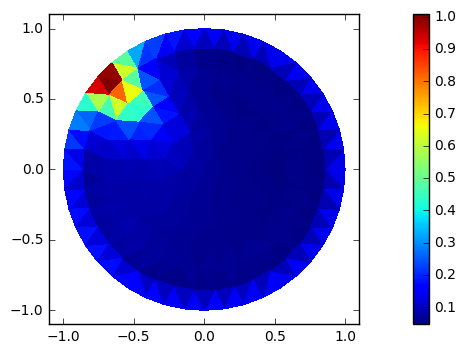

In [418]:
rhomin = 0.01
rho = baseline_fields[:,run_time-1][:,None]
rho[rho < rhomin] = rhomin
conduct = np.log(1./rho)
p = bpdes.collocate([()], [()], 
                    [(baseline_xy, conduct)],
                    proposal_op_system, 
                    np.array([0.12, 1.0]))

true_field, _ = p(proposal_design)
true_field = true_field.ravel()
plot_circle(proposal_design[:,0], proposal_design[:,1], np.exp(true_field))

In [419]:
# TO DO:
# * Swap to simulating only a lower dimensional version of the field
proposal_dot_mat = np.dot(proposal_lhs_mat, proposal_cov_inv)
def theta_to_a(theta, sz_int, sz_bdy):
    theta = np.real_if_close(theta)
    theta_mod = np.dot(proposal_dot_mat, theta[:,None])
    kappa_int = theta_mod[:sz_int]
    kappa_bdy = theta_mod[sz_int:sz_int+sz_bdy]
    grad_kappa_x = theta_mod[sz_int+sz_bdy:2*sz_int+sz_bdy]
    grad_kappa_y = theta_mod[2*sz_int+sz_bdy:]
    return kappa_int, kappa_bdy, grad_kappa_x, grad_kappa_y

In [420]:
import scipy.optimize
def phi_const(k):
    return phi(k*np.ones(proposal_cov.shape[0]))
best_const = scipy.optimize.minimize_scalar(phi_const)

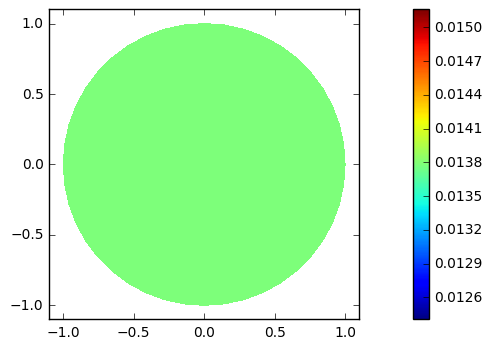

In [421]:
mcmc.pcn.sqrtm_mode = mcmc.pcn.SQRTM_SCIPY
proposal = mcmc.pcn.proposal(0.005, proposal_cov)
#kappa_0 = np.random.multivariate_normal(np.zeros(proposal_cov.shape[0]), proposal_cov)
#kappa_0 = proposals[-1,:]
#kappa_0 = dummy_true_field[:len(full_design)]
kappa_0 = best_const.x*np.ones(proposal_cov.shape[0])
plot_circle(proposal_design[:,0], proposal_design[:,1], np.exp(kappa_0))

In [422]:
print phi(kappa_0, False)
print phi(true_field, False)

8113180.01333
7809825868.36


In [423]:
proposals, acceptances = mcmc.pCN(10000, proposal, phi, kappa_0)

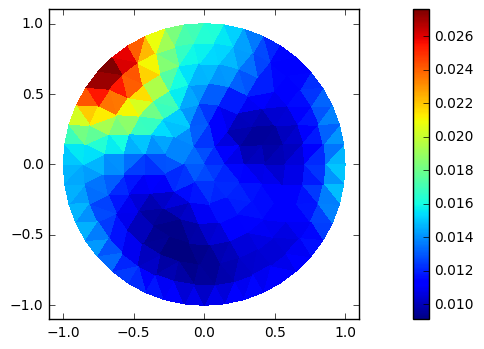

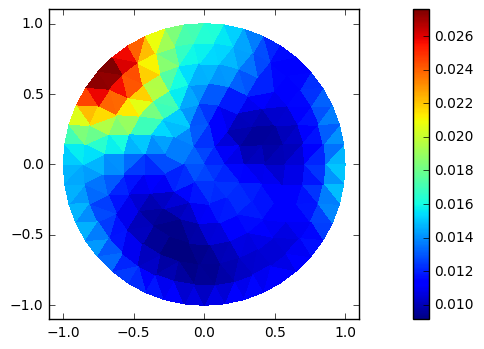

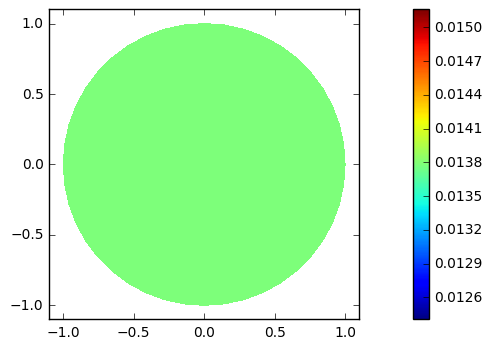

In [424]:
thin = 1
burn = int(proposals.shape[0]) / 2


recovered_field = proposals[burn::thin, :len(full_design)].mean(axis=0)
plot_circle(proposal_design[:,0], proposal_design[:,1], np.exp(recovered_field))
plt.savefig('results/t={}_field.pdf'.format(run_time))
plt.figure()
plot_circle(proposal_design[:,0], proposal_design[:,1], np.exp(proposals[-1, :len(full_design)]))
plt.figure()
plot_circle(proposal_design[:,0], proposal_design[:,1], np.exp(kappa_0[:len(full_design)]))

In [425]:
print phi(recovered_field)
print phi(kappa_0)

24631.3573618
8113180.01333


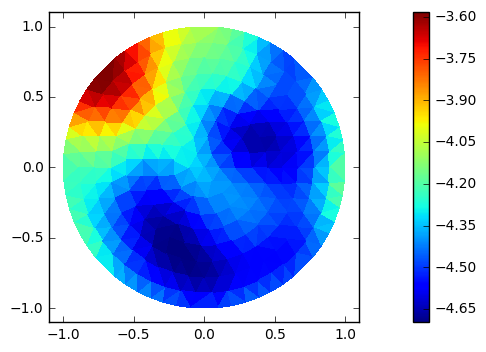

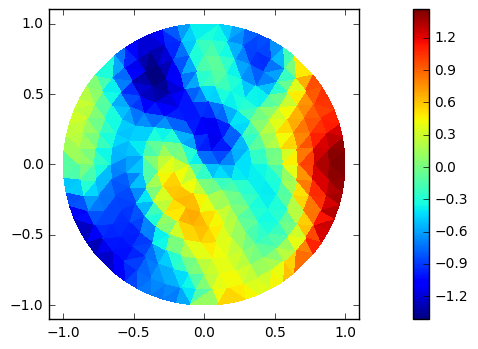

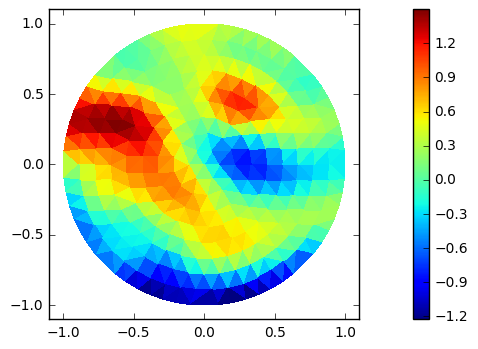

In [426]:
a_int, a_bdy, a_x, a_y = theta_to_a(proposals[-1,:], len(modified_design_int), len(modified_design_bdy))
plot_circle(modified_design_int[:,0], modified_design_int[:,1], a_int)
plt.figure()
plot_circle(modified_design_int[:,0], modified_design_int[:,1],a_x)
plt.figure()
plot_circle(modified_design_int[:,0], modified_design_int[:,1], a_y)

# Diagnostics

In [427]:
field_to_test = recovered_field

In [428]:
phi(field_to_test, True)

Sigma diag: [ 0.00081985  0.0007381   0.000799    0.00077542  0.00081357  0.00075968
  0.00088186  0.00078931]	Condition:4809.27820017 	 Augmented Condition: 942.605938222
Model|True
 [[ 43.37593072  43.32      ]
 [ 23.42147352  23.37      ]
 [ 23.1205085   23.19      ]
 [ 22.2673514   22.16      ]
 [ 22.08250173  21.81      ]
 [ 20.40441455  19.94      ]
 [ 18.33266268  17.9811    ]]
Likelihood: -634.931070232   |   Residual: 1.37272609369
Model|True
 [[ 23.88963168  23.67      ]
 [ 45.88474655  45.02      ]
 [ 30.40515757  29.58      ]
 [ 28.17145445  27.77      ]
 [ 27.13840242  26.71      ]
 [ 24.09417837  24.29      ]
 [ 20.35928307  20.7011    ]]
Likelihood: -2556.25388848   |   Residual: 3.27703123137
Model|True
 [[ 22.31211049  22.93      ]
 [ 28.18869018  29.13      ]
 [ 39.8243965   40.37      ]
 [ 28.53613411  29.64      ]
 [ 26.79845351  28.75      ]
 [ 25.2136566   26.12      ]
 [ 21.39550802  21.5711    ]]
Likelihood: -10037.5121611   |   Residual: 6.24215059027
Model|Tru

24631.357361816383

In [429]:
p = construct_posterior(field_to_test)
mu_mult, cov = p.no_obs_posterior(np.column_stack([full_design, np.empty((full_design.shape[0],3))]))

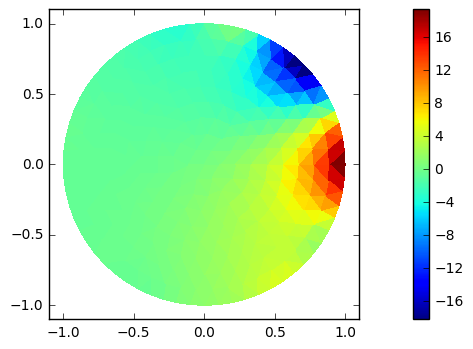

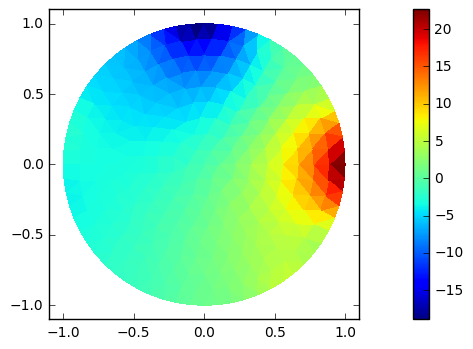

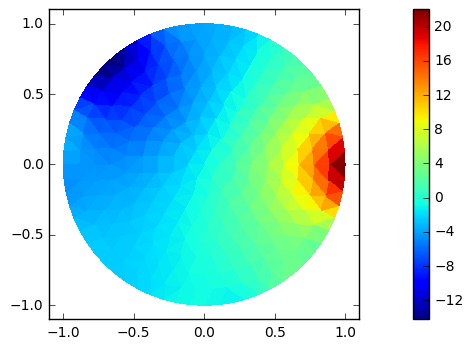

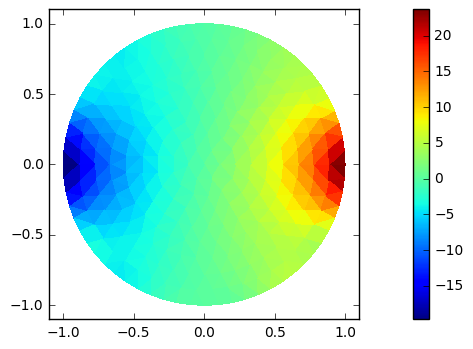

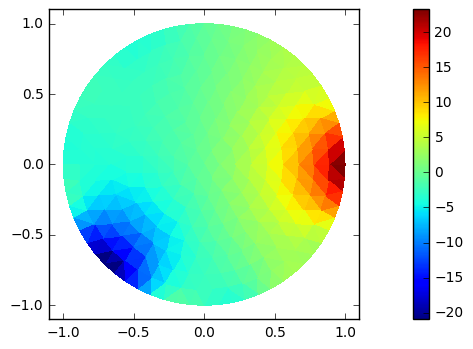

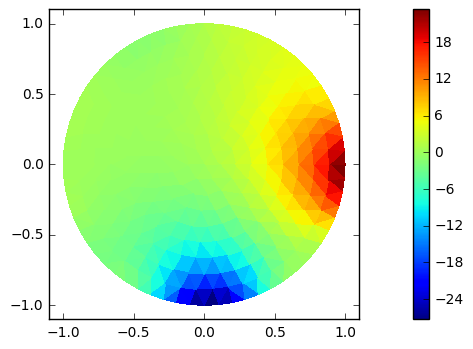

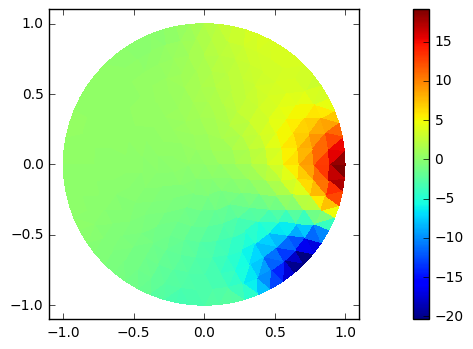

In [430]:
for i in xrange(stim_pattern.shape[0]):
    mu = mu_mult.dot(np.row_stack([
                np.zeros((len(modified_design_int), 1)),
                stim_pattern[i][:,None]
                ]
                             ))
    plt.figure()
    plot_circle(full_design[:,0], full_design[:,1], mu)

In [431]:
np.save('results/t={}_samples.npy'.format(run_time), recovered_field)

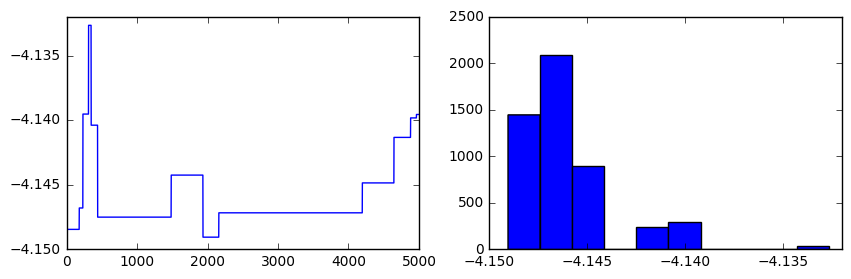

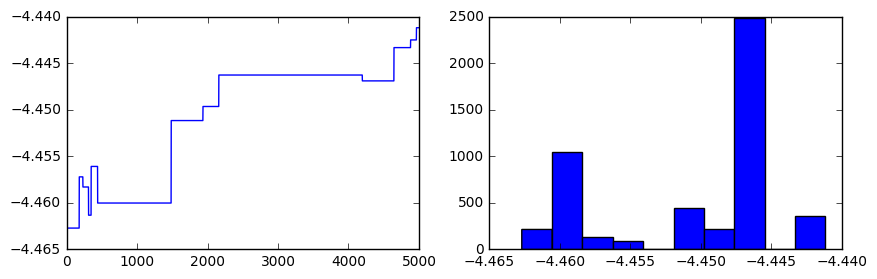

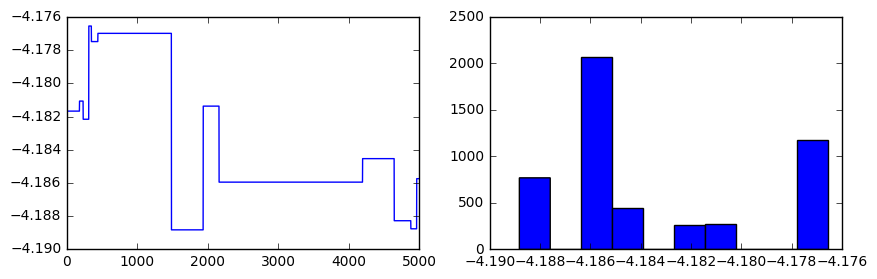

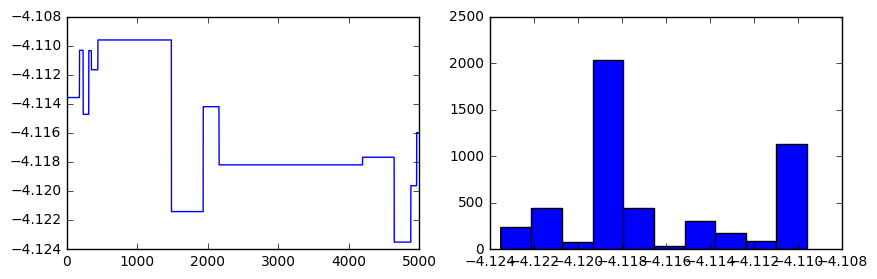

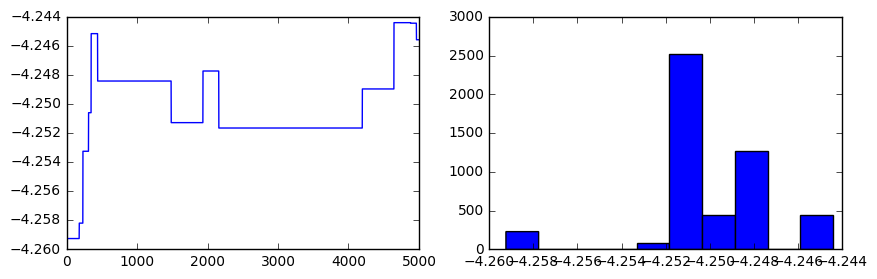

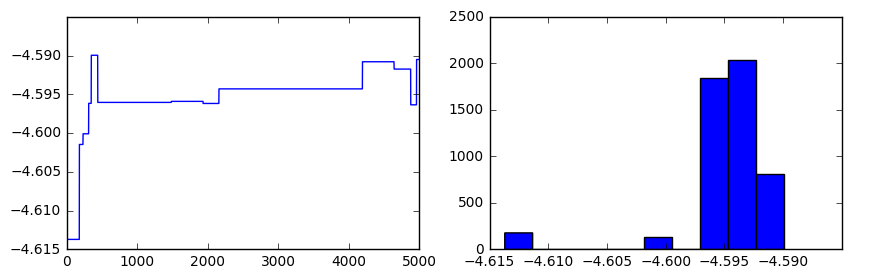

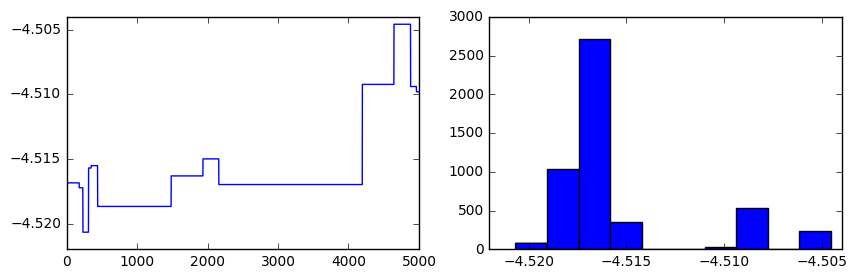

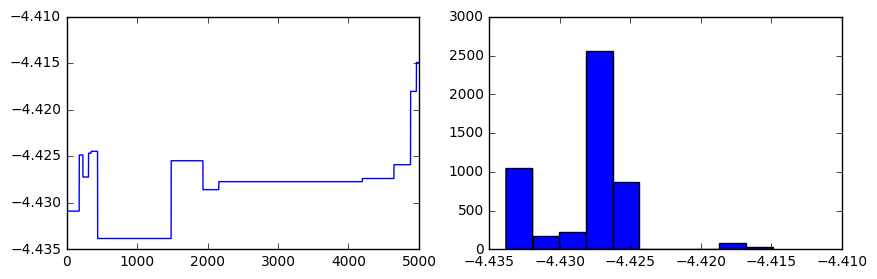

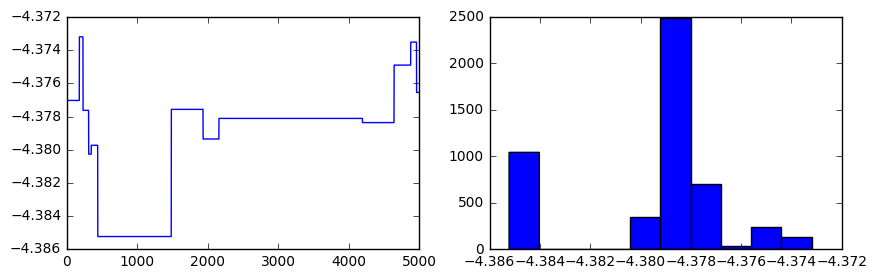

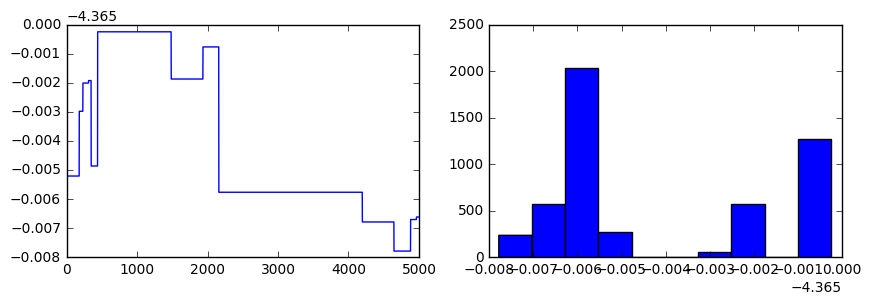

In [432]:
for i in np.random.choice(proposals.shape[1], 10):
    plt.figure(figsize=(10,3))
    plt.subplot(121)
    plt.plot(proposals[burn::thin,i])
    plt.subplot(122)
    plt.hist(proposals[burn::thin,i])

In [433]:
phi(proposals[-1,:], True)

Sigma diag: [ 0.00081878  0.00073808  0.00079596  0.00076562  0.00080553  0.0007609
  0.00086752  0.00078107]	Condition:4825.29402119 	 Augmented Condition: 938.771707568
Model|True
 [[ 43.37090327  43.32      ]
 [ 23.47469876  23.37      ]
 [ 23.24797142  23.19      ]
 [ 22.47072807  22.16      ]
 [ 22.42991271  21.81      ]
 [ 21.00695408  19.94      ]
 [ 18.6760244   17.9811    ]]
Likelihood: -1630.37812322   |   Residual: 2.90609270565
Model|True
 [[ 23.99366116  23.67      ]
 [ 45.86259937  45.02      ]
 [ 30.29373235  29.58      ]
 [ 28.12992926  27.77      ]
 [ 27.27956081  26.71      ]
 [ 24.34124414  24.29      ]
 [ 20.45459148  20.7011    ]]
Likelihood: -2390.0736005   |   Residual: 3.1072356048
Model|True
 [[ 22.27582898  22.93      ]
 [ 27.97486411  29.13      ]
 [ 39.42041491  40.37      ]
 [ 28.35972444  29.64      ]
 [ 26.98074897  28.75      ]
 [ 25.74644031  26.12      ]
 [ 21.74021388  21.5711    ]]
Likelihood: -9050.62320626   |   Residual: 6.3510921584
Model|True
 [

23570.138356280931

In [434]:
phi(kappa_0, True)

Sigma diag: [ 0.00092848  0.00092987  0.00092934  0.00092872  0.00093012  0.00092874
  0.00092932  0.0009299 ]	Condition:6524.177118 	 Augmented Condition: 1725.718847
Model|True
 [[ 49.9209955   43.32      ]
 [ 33.81628219  23.37      ]
 [ 27.76481937  23.19      ]
 [ 25.73384585  22.16      ]
 [ 24.22904879  21.81      ]
 [ 22.2063419   19.94      ]
 [ 16.13143233  17.9811    ]]
Likelihood: -885074.71096   |   Residual: 31.7310012838
Model|True
 [[ 33.81317617  23.67      ]
 [ 67.65849825  45.02      ]
 [ 45.48555773  29.58      ]
 [ 37.37923192  27.77      ]
 [ 33.84335787  26.71      ]
 [ 30.31130973  24.29      ]
 [ 22.20606145  20.7011    ]]
Likelihood: -849481.64549   |   Residual: 72.9560930988
Model|True
 [[ 27.76178446  22.93      ]
 [ 45.48423476  29.13      ]
 [ 73.22679932  40.37      ]
 [ 48.99194598  29.64      ]
 [ 39.39138407  28.75      ]
 [ 33.84395118  26.12      ]
 [ 24.22902778  21.5711    ]]
Likelihood: -2952126.81514   |   Residual: 94.4180275312
Model|True
 [[ 

8113180.0133278817